### GA Data Science - Final Project
#### James Clark

The value of real estate can be extremely subjective. Almost all listings can be summarrized by a few common, objective features - square footage, number of bedrooms and bathrooms, lot size. There are other subjective features that can be used to help summarize real estate listings found within the listing description.

The goal of this analysis is to use the language used to describe the property listing to determine other features not already enumerated. Additionally, these additional features could be used to help categorize these listings, and a possible value.

Analysis will be done using a set of Trulia property listing data found on kaggle.com (https://www.kaggle.com/promptcloud/real-estate-data-from-trulia).


#### Some initial questions:
* What national trends do we see from our data?
* What are common words used in descriptions based on the listing's location?
* How do objective features - square footage, lot size, number of beds and baths, affect the class of a listing?
* How does the description affect categories of listings?
* How do we use both objective, and subjective features to categorize listings?
* Can we predict a value based on both objective and subjective features for a listing?

In [384]:
! pip install stringcase
! pip install fold_to_ascii
! pip install plotly-geo
! pip install us
! pip install geopandas
! pip install pyshp
! pip install shapely

In [385]:
import pandas as pd
import stringcase
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from fold_to_ascii import fold
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import us
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN, KMeans
from sklearn.model_selection import train_test_split

%matplotlib inline

In [386]:
def pluck_number(text):
    number_only = re.sub("[^\d\.]+", "", str(text)) if pd.notnull(text) else 0
    return 0 if number_only == "" else float(number_only)
    
def drop_unused_columns(df: pd.DataFrame):    
    columns_to_keep = {'description', 'price', 'sqr_ft', 'longitude', 'latitude', 'lot_size', 'beds', 'bath', 'state'}
    df.drop(columns = df.columns.difference(columns_to_keep), inplace = True)
    
def numerize_columns(df: pd.DataFrame):    
    df.sqr_ft.fillna(0, inplace = True)
    df.lot_size.fillna(df.sqr_ft, inplace = True)
    df.beds.fillna(0, inplace = True)
    df.bath.fillna(0, inplace = True)
    for column in ['sqr_ft', 'price', 'lot_size']:
        df[column] = df[column].apply(pluck_number)
    
def remove_rows_with_empty_descriptions(df: pd.DataFrame):    
    df.dropna(subset = ['description'], inplace = True)
    
def remove_rows_without_sqft_beds_baths(df: pd.DataFrame):
    df.dropna(subset = ['sqr_ft'], inplace = True)
    df = df[(df.sqr_ft > 0) & (df.beds > 0) & (df.bath > 0)]
    
def clean_text(text: str):
    punctuations="?:!.,;-@/*&$()_="
    sentence_words = nltk.word_tokenize(text)
    stemmer = SnowballStemmer('english')    
    custom_stop_words = ['home', 'room', 'latitude', 'longitude', 'price', 'new', 'live', 'great']
    
    words = [word.lower() for word in sentence_words if word.lower() not in stopwords.words('english') + custom_stop_words]    
    words = [word for word in words if word not in punctuations]    
    words = [fold(word) for word in words]        
    words = [stemmer.stem(word) for word in words]    
    words = [word for word in words if not re.search('(.)\1{2,}', word)] #Any word with a character repeating 3 or more times
    words = [word for word in words if not re.search('\d+', word)]    
    words = [word for word in words if not re.search('_', word)]
    words = [word for word in words if not re.search('^[^a,e,i,o,u]+$', word)]
    
    return ' '.join(words)
    
def clean_data(df: pd.DataFrame):    
    df.columns = [stringcase.snakecase(column.lower()) for column in df.columns]        
    remove_rows_with_empty_descriptions(df)    
    drop_unused_columns(df)            
    numerize_columns(df)            
    df.description = df.description.apply(clean_text)
    df = df[df.price > 0]
    

def tokenize_descriptions(df: pd.DataFrame):
    vect = TfidfVectorizer(max_features = 200)    
    text_df = pd.DataFrame(vect.fit_transform(df.description).toarray(), columns=vect.get_feature_names())    
    return text_df
    
def tokenize_descriptions_and_save(df: pd.DataFrame, force_refresh = False) -> pd.DataFrame:
    filename = 'data/cache/tokenized_descriptions.csv'
    if not force_refresh and os.path.isfile(filename):
        return pd.read_csv(filename)

    text_df = tokenize_descriptions(df)
    text_df.to_csv(filename, index = False)
    return text_df
            
def load_and_clean_train_test_data(force_refresh = False) -> pd.DataFrame:
    input_filename = 'data/home/sdf/marketing_sample_for_trulia_com-real_estate__20190901_20191031__30k_data.csv'
    cache_filename = 'data/cache/cleaned_marketing_sample_for_trulia_com.csv'
    if not force_refresh and os.path.isfile(cache_filename):
        df = pd.read_csv(cache_filename)
        df['sqr_ft'] = df['sqr_ft'].apply(pluck_number)
        return df
    
    df = pd.read_csv(input_filename)
    clean_data(df)
    df.to_csv(cache_filename, index = False)    
    return df   

## Clean the data, and tokenize the listing descriptions

#### Take the top 200 words in the description - there are almost 30000 unique terms if we took all of them into account.

In [387]:
#Set force_refresh to True to reload it all from scratch.
force_refresh = False
df = load_and_clean_train_test_data(force_refresh)

#Filter out rows that have no square footage, beds, or baths
df = df[(df.sqr_ft > 0) & (df.beds > 0) & (df.bath > 0) & (df.price > 0)]

#Filter out outliers in square footage, lot size, and price
df = df[(np.abs(stats.zscore(df[['price', 'sqr_ft', 'lot_size']])) < 3).all(axis=1)]
df.price = df.price.astype('float')

df.reset_index(inplace = True)

df.rename(columns = {'bath': 'baths'}, inplace = True)

text_df = tokenize_descriptions_and_save(df, force_refresh)
text_df.reset_index(inplace = True)
df = df.merge(text_df, on = 'index')
df.set_index('index', inplace = True)

seed = 42
train_X, test_X, train_y, test_y = train_test_split(df, df.price, random_state = seed, test_size = 0.2)
df = train_X.copy()

In [388]:
df.head()

,description,price,sqr_ft,longitude,latitude,lot_size,beds,baths,state,access,...,walk,wall,washer,water,welcom,well,window,wood,yard,year
index,,,,,,,,,,,,,,,,,,,,,
9499,fulli renov well maintain bedroom bathroom uni...,474999.0,1155.0,-118.20094,33.773520,1.25,3.0,2.0,CA,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17849,amaz view privaci locat gate communiti sandi r...,377000.0,2535.0,-117.30159,47.703125,10327.00,5.0,3.0,WA,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17010,perfect locat ground unit end unit bedroom ful...,165000.0,1005.0,-89.50789,43.049046,1005.00,2.0,2.0,WI,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7094,locat bedroom full bath condo upper level incl...,120000.0,996.0,-115.24123,36.157997,2116.00,2.0,2.0,NV,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15940,gorgeous garden prestigi orchard park wonder d...,529900.0,3197.0,-101.89941,33.496597,9950.00,3.0,2.0,TX,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [389]:
df.shape

(18555, 209)

In [390]:
text_columns = df.columns.difference(['sqr_ft', 'lot_size', 'beds', 'baths', 'price', 'latitude', 'longitude', 'description', 'state'])

<hr/>

## Analysis of Listings based on Square Footage, Beds, Baths, and Lot Size
*What national trends do we see from our data?*

### Nationwide

In [391]:
df.price.describe()

count    1.855500e+04
mean     4.637195e+05
std      4.717378e+05
min      1.000000e+03
25%      1.999000e+05
50%      3.200000e+05
75%      5.390000e+05
max      3.650000e+06
Name: price, dtype: float64

We can that for the entire nation within our dataset, the average listing price is \\$463,716, and the median (50th percentile) is \\$320,000.

The most expensive listing in our dataset is \\$3,650,000.

In [392]:
price_per_sqr_ft = df.price / df.sqr_ft
price_per_sqr_ft.replace(np.inf, 0, inplace = True)
price_per_sqr_ft.dropna(inplace = True)
price_per_sqr_ft.describe()

count    1.855500e+04
mean     3.673268e+02
std      9.808437e+03
min      4.147657e-01
25%      1.193191e+02
50%      1.659913e+02
75%      2.600750e+02
max      1.100000e+06
dtype: float64

We can see here that the median price per square foot is \\$165.99, and our average is \\$367.33.

### By State

In [393]:
count_by_state = df.groupby('state').description.count()
fig = go.Figure(data=go.Choropleth(
    locations=count_by_state.index,
    z = count_by_state.values,
    locationmode = 'USA-states',
    colorscale = 'Reds'
))

fig.update_layout(
    title_text = 'Number of Listings per State',
    geo_scope='usa',
)
fig.show()

In [394]:
price_by_state = df.groupby('state').price.mean()
fig = go.Figure(data=go.Choropleth(
    locations=price_by_state.index,
    z = price_by_state.values,
    locationmode = 'USA-states',
    colorscale = 'Reds'
))

fig.update_layout(
    title_text = 'Average Price per State in USD',
    geo_scope='usa',
)
fig.show()

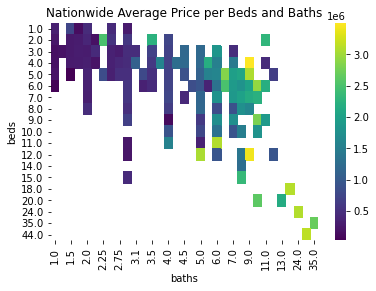

In [395]:
beds_baths_price = df[['beds', 'baths', 'price']].reset_index()
sns.heatmap(beds_baths_price.groupby(['beds', 'baths']).mean().price.unstack(), cmap='viridis')
plt.title('Nationwide Average Price per Beds and Baths')
plt.show()

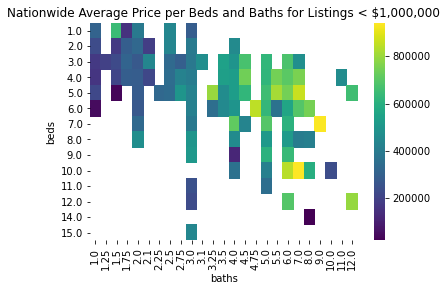

In [396]:
sns.heatmap(beds_baths_price[beds_baths_price.price < 1000000].groupby(['beds', 'baths']).mean().price.unstack(), cmap='viridis')
plt.title('Nationwide Average Price per Beds and Baths for Listings < $1,000,000')
plt.show()

#### Takeaways
* Most of our listings are in Texas
* Our data set is missing information for ~1/3 of the USA
* Average listing price varies wildly nationwide
* On average, New York, California, and Massachusetts are the most expensive
* Price per bed has a sharp increase after the third bedroom (total price < \\$1,000,000)
* Price per bathroom has a sharp increase after exceeding the number of bedrooms (total price < \\$1,000,000)

<hr/>

### Let's see what terms are most relevant in our listings...
*What are common words used in descriptions based on the listing's location?*

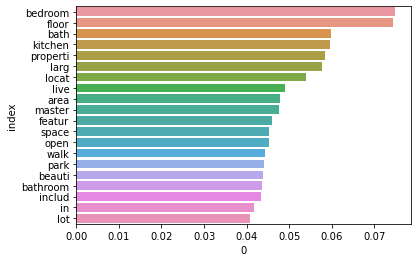

In [397]:
#Most relevant terms
sns.barplot(data = df[text_columns].mean().sort_values(ascending = False).reset_index().head(20), y = 'index', x = 0)

In [398]:
import us
#Most relevant terms
text_with_state_df = df[text_columns].copy()
text_with_state_df['__state'] = df.state

grouped_df = text_with_state_df.groupby('__state').median()
grouped_df.reset_index(inplace = True)
grouped_df.set_index('__state', inplace = True)
top_terms_df = grouped_df.transpose().idxmax()
top_terms_df

__state
AK      floor
AL    bedroom
AZ    bedroom
CA    bedroom
CO    bedroom
DC      floor
FL    bedroom
GA    bedroom
IA    bedroom
ID      floor
IL      floor
IN      floor
KS      floor
KY    kitchen
LA      floor
MA      floor
MD      floor
MI    bedroom
MN      floor
NC    bedroom
NE      floor
NJ    bedroom
NM    bedroom
NV    bedroom
NY    bedroom
OH      floor
OK    bedroom
OR    bedroom
PA    bedroom
TN      floor
TX    bedroom
VA    bedroom
WA    bedroom
WI    bedroom
dtype: object

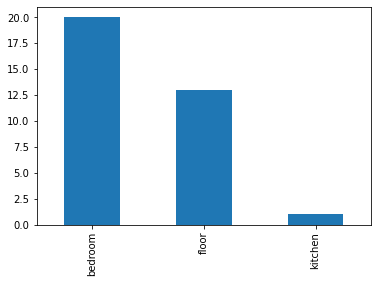

In [399]:
top_terms_df.value_counts().plot(kind = 'bar')

#### Takeaways
* The most salient words in these descriptions do not vary much
* "Floor" and "bedroom" are the most salient, with both taking up almost all of our states

<hr/>

### Clustering
** How do objective features - square footage, lot size, number of beds and baths, affect the class of a listing?*

#### Clustering by Stats - Square footage, beds, baths, lot size

##### Tuning the cluster count

Text(0.5, 1.0, 'The Elbow Method')

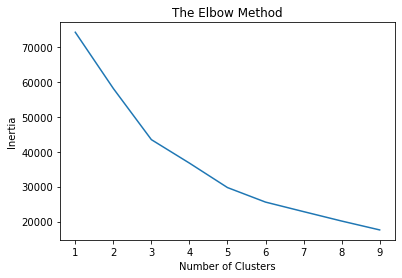

In [400]:
inertia = []
n_clusters = []
stats_kms = []

for i in range(1,10):
    km = KMeans(n_clusters = i)    
    km.fit(StandardScaler().fit_transform(df[['beds', 'baths', 'sqr_ft', 'lot_size']]))
    n_clusters.append(i)
    inertia.append(km.inertia_)
    stats_kms.append(km)
    
plt.plot(n_clusters, inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')

* The "Elbow Method" shows that three, or six clusters are the ideal amount

In [401]:
stats_km = stats_kms[5]
df['stats_label'] = stats_km.labels_

In [402]:
pd.Series(data = stats_km.labels_).value_counts()

2    6196
0    5920
4    4723
1    1693
3      20
5       3
dtype: int64

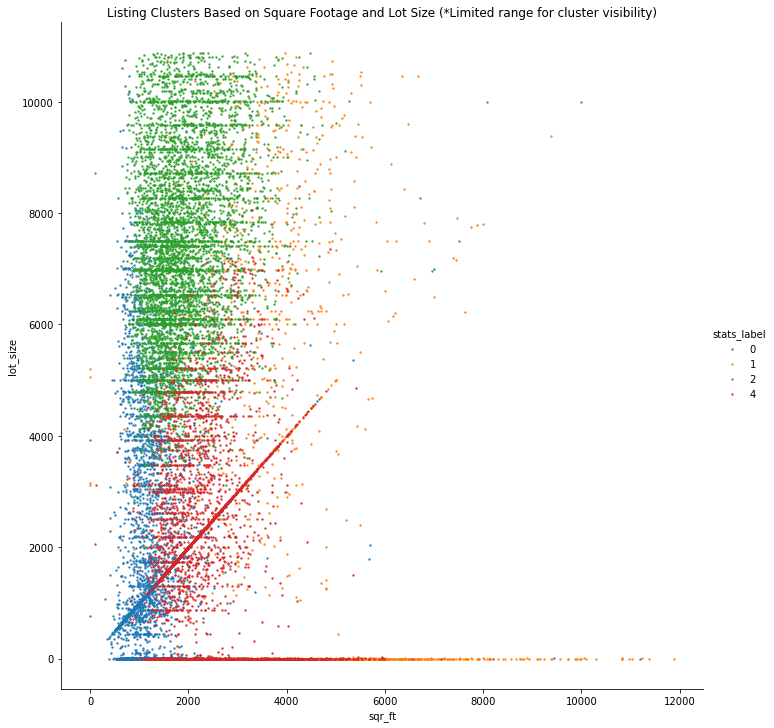

In [403]:
sns.lmplot(data = df[(df.sqr_ft < 12000) & (df.lot_size < 12000)], x = 'sqr_ft', y = 'lot_size', hue = 'stats_label', fit_reg=False, scatter_kws={"s": 2}, height = 10, aspect = 1)
plt.title('Listing Clusters Based on Square Footage and Lot Size (*Limited range for cluster visibility)')
plt.show()

* There are five visible groups, which could be targeted for marketing
* The sixth group caught a lot of outliers
* Two of our groups begin to separate where square footage > ~1500sqft
* There is a clear line where square footage equals lot size, and another where lot size is zero - suggesting the sale of an apartment
* Cases where square footage is slightly greater than lot size might suggest a single-family listing with multiple floors, built upon a small lot
* Cases where square footage is much greater than lot size might suggest the difference between single-family homes, and multi-tenant buildings
* Listings within 0-4000 square feet, and a lot size >= 4000 square feet make up another group

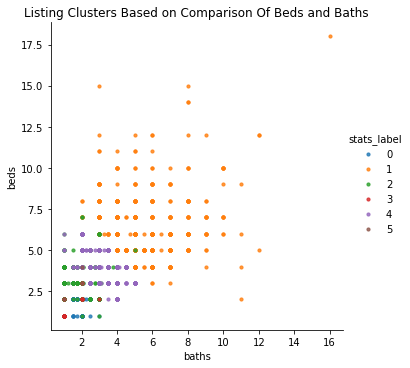

In [404]:
sns.lmplot(data = df[(df.beds < 20) & (df.baths < 20)], x = 'baths', y = 'beds', hue = 'stats_label', fit_reg=False, scatter_kws={"s": 10})
plt.title('Listing Clusters Based on Comparison Of Beds and Baths')
plt.show()

* There is some difference in clustering between 0-6 baths and 0-6 beds, but still a lot of overlap

In [405]:
labels = df.stats_label.unique()
labels.sort()

for label in labels:
    print('Label Group ' + str(label))
    print(df[['price', 'sqr_ft', 'beds', 'baths']][df.stats_label == label].describe())
    print('\n\n')
    

Label Group 0
              price         sqr_ft        beds        baths
count  5.920000e+03    5920.000000  5920.00000  5920.000000
mean   3.501434e+05    1744.195270     2.20152     1.708285
std    3.608195e+05    6742.520356     0.67246     0.600542
min    1.000000e+03       1.000000     1.00000     1.000000
25%    1.458295e+05     962.000000     2.00000     1.000000
50%    2.449000e+05    1200.000000     2.00000     2.000000
75%    4.249000e+05    1522.250000     3.00000     2.000000
max    3.600000e+06  169000.000000     4.00000     3.000000



Label Group 1
              price        sqr_ft         beds        baths
count  1.693000e+03   1693.000000  1693.000000  1693.000000
mean   1.068969e+06   4272.594802     5.486119     4.950384
std    7.781698e+05   1814.317820     1.945615     1.698100
min    2.180000e+04      1.000000     2.000000     2.000000
25%    4.990000e+05   3210.000000     5.000000     4.000000
50%    7.750000e+05   3963.000000     5.000000     5.000000
75%    1.

#### Takeaways
* We can see there are six categories of listings
* Between our groups based on square footage/lot size/beds/baths:
    * Some inferences can be made based on average number of beds and baths per cluster
        * Smaller bed/bath counts appear to be single-family homes
        * One group with an extraordinary maximum number of beds appears to be an apartment building for sale
* These categories can be used to determine market segments and market houses tailored to the buyer's budget


<hr/>

### Clustering By Descriptions
*How do these words correlate with different classes of property listings?*

##### Tuning the cluster count

Text(0.5, 1.0, 'The Elbow Method')

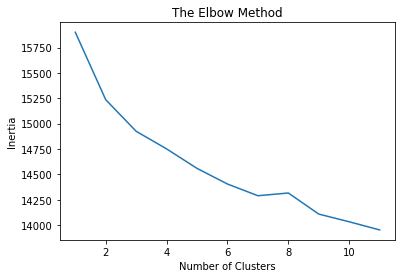

In [406]:
inertia = []
n_clusters = []
text_kms = []

for i in range(1,12):
    km = KMeans(n_clusters = i)    
    km.fit(df[text_columns])
    n_clusters.append(i)    
    inertia.append(km.inertia_)
    text_kms.append(km)
    
plt.plot(n_clusters, inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')

* The "Elbow Method" shows that three clusters is the ideal amount

In [407]:
text_km = text_kms[2]

### Visualizing text clustering
* We will need to use Principal Component Analysis to reduce the data from 200+ dimensions down to two

In [408]:
standardized_text_df = StandardScaler().fit_transform(df[text_columns].copy())
text_pca = PCA(n_components = 2)
text_principal_components = text_pca.fit_transform(standardized_text_df)
text_pca_df = pd.DataFrame(data = text_principal_components, columns = ['pca1', 'pca2'])
text_pca_df['label'] = text_km.labels_

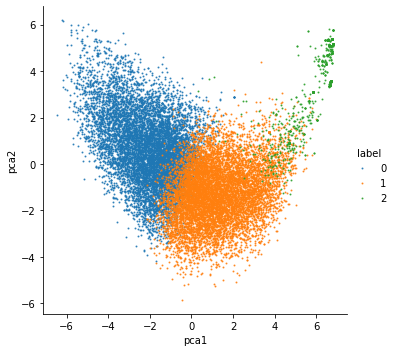

In [409]:
sns.lmplot(data = text_pca_df, x = 'pca1', y = 'pca2', hue = 'label', fit_reg=False, scatter_kws={"s": 1})

In [410]:
df['text_label'] = text_km.labels_    
df.groupby('text_label').mean()[text_columns].transpose().idxmax()

text_label
0     bedroom
1       locat
2    properti
dtype: object

In [411]:
df['text_label'] = text_km.labels_
df.groupby('text_label').price.describe().reset_index()

,text_label,count,mean,std,min,25%,50%,75%,max
0,0,8766.0,462236.761008,472868.344983,1000.0,199900.0,320000.0,525000.0,3650000.0
1,1,8594.0,466820.355131,472101.802664,1000.0,199900.0,323522.5,549000.0,3650000.0
2,2,1195.0,452296.494561,460849.163456,1000.0,195000.0,315000.0,518730.0,3600000.0


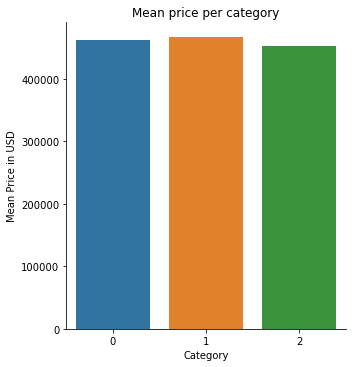

In [412]:
sns.catplot(data = df.groupby('text_label').price.describe().reset_index(), x = 'text_label', y = 'mean', kind = 'bar')
plt.title('Mean price per category')
plt.xlabel('Category')
plt.ylabel('Mean Price in USD')
plt.show()

#### Takeaways
* We can see a clear separation in clusters when grouping by words used in the description
* The average, median, and percentile prices for all three categories are near identical
* We cannot determine a listing value based on the description alone

<hr/>

## Using both objective and subjective driven categories
*How do we use both objective, and subjective features to categorize listings?*

In [413]:
#Combine the categories from stats and text above into a new category
import itertools
new_categories = list(itertools.product(df.stats_label.unique(), df.text_label.unique()))

### Segmenting our market based both listing stats and description

In [414]:
combined_category = []
for row in df.iterrows():    
    combined_category.append(new_categories.index((row[1]['stats_label'], row[1]['text_label'])))
    
df['combined_category_label'] = combined_category
text_pca_df['combined_category_label'] = combined_category

In [415]:
combined_category_word = df.groupby('combined_category_label').mean()[text_columns].transpose().idxmax()

In [416]:
combined_stats = df.groupby('combined_category_label').mean()[['sqr_ft', 'lot_size', 'beds', 'baths', 'price']]

In [417]:
combined_stats['word'] = combined_category_word
combined_stats

,sqr_ft,lot_size,beds,baths,price,word
combined_category_label,,,,,,
0,1353.727053,1752.153092,2.277778,1.726449,3.474690e+05,properti
1,1645.025659,1810.561427,2.196837,1.716380,3.461764e+05,floor
2,1910.971439,1820.141939,2.194664,1.696806,3.548008e+05,locat
3,1909.428941,7372.720930,3.395349,2.275840,3.381260e+05,properti
4,1952.261773,7359.231988,3.428670,2.311617,3.462601e+05,bedroom
5,1997.194454,7391.413215,3.416980,2.281821,3.460497e+05,locat
6,4225.766990,2714.924951,5.504854,4.932039,1.034424e+06,properti
7,4273.216182,3272.412794,5.475348,4.949747,1.069591e+06,floor
8,4278.016270,3021.609474,5.494368,4.953379,1.072807e+06,locat


In [418]:
df.combined_category_label.value_counts()

5     2921
4     2888
1     2845
2     2661
10    2229
11    2203
8      799
7      791
0      414
3      387
9      291
6      103
14      10
13      10
16       3
Name: combined_category_label, dtype: int64

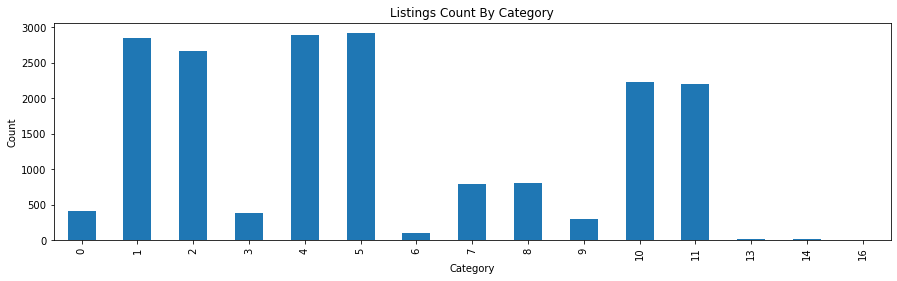

In [419]:
df.combined_category_label.value_counts(sort = False).sort_index().plot(kind = 'bar', figsize = (15, 4))
plt.title('Listings Count By Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

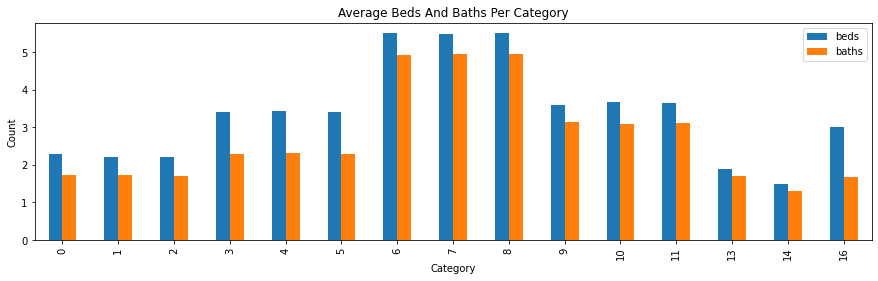

In [420]:
combined_stats[['beds', 'baths']].plot(kind = 'bar', figsize = (15, 4))
plt.title('Average Beds And Baths Per Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

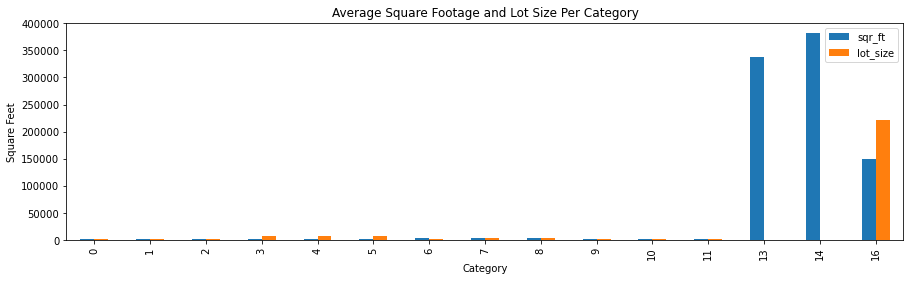

In [421]:
combined_stats[['sqr_ft', 'lot_size']].plot(kind = 'bar', figsize = (15, 4))
plt.title('Average Square Footage and Lot Size Per Category')
plt.xlabel('Category')
plt.ylabel('Square Feet')
plt.show()

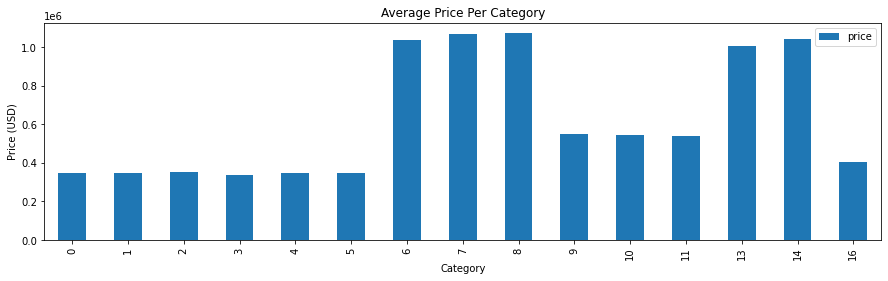

In [422]:
combined_stats[['price']].plot(kind = 'bar', figsize = (15, 4))
plt.title('Average Price Per Category')
plt.xlabel('Category')
plt.ylabel('Price (USD)')
plt.show()

#### Takeaways
* Once we combined the categories found using the listing stats and listing description, we can get a better idea of what kind of listing each category corresponds to:
    * Categories 0-5 correspond to single-family homes
        * Categories 0, 1, and 2 appear to be single-family sized homes with very small yards - perfect to market to first time home buyers
        * Categories 3, 4, and 5 appear to be single-family sized homes with larger than normal yards - perfect to market to those who enjoy a beautiful landscape
    * Categories 6, 7, and 8 correspond to mansions containing 5 or more beds and baths, with high prices
    * Categories 13 and 14 appear to be multi-tennant buildings - often billed as an "opportunity" investment (most salient term for category 14)
    * Category 16 appears to be a catch-all for houses with large square footage, or lots with a large square footage, or both
* These enhanced listing categories allow real estate agents to make informed marketing decisions based on how to meet buyer and seller needs, and remain cognizant of the market inventory

<hr/>

### Predictions

##### Some last minute train/test data cleanup

In [423]:
test_Y = test_X.price
test_X.drop(columns = ['price', 'description', 'latitude', 'longitude', 'state'], inplace = True)
train_X.drop(columns = ['price', 'description', 'latitude', 'longitude', 'state'], inplace = True)

##### An initial Random Forest model

In [424]:
def evaluate(model, test_features, test_values):
    predictions = model.predict(test_features)
    errors = (predictions - test_values).abs()    
    pct_error = (errors / test_values) * 100
    accuracy = 100 - pct_error.mean()
    print('Model Performance')
    print('Average Error: ${:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%'.format(accuracy))
    return accuracy

In [425]:
initial_rf = RandomForestRegressor(n_estimators = 20, max_depth = 16)
initial_rf.fit(train_X, train_y)

RandomForestRegressor(max_depth=16, n_estimators=20)

In [426]:
initial_accuracy = evaluate(initial_rf, test_X, test_y)

Model Performance
Average Error: $225535.2725
Accuracy = -10148.17%


##### Which features are important to this initial model?

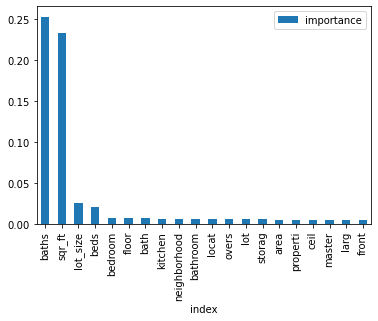

In [427]:
pd.DataFrame({
    'index': train_X.columns, 
    'importance': initial_rf.feature_importances_
}).set_index('index').sort_values(by = 'importance', ascending = False).head(20).plot(kind = 'bar')

##### Tuning the model

In [428]:
#PCA-ified train test split so we can crank through random forest iterations
pca_train_X = train_X.copy()
pca_test_X = test_X.copy()

pca = PCA(n_components = 2)
pca_train_X = pd.DataFrame(data = pca.fit_transform(StandardScaler().fit_transform(pca_train_X)), index = train_y.index, columns = ['pca1', 'pca2'])
pca_test_X = pd.DataFrame(data = pca.fit_transform(StandardScaler().fit_transform(pca_test_X)), index = test_y.index, columns = ['pca1', 'pca2'])


# Build parameters used to tune the random forest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 21)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]

params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': [True, False]
}

cv = RandomizedSearchCV(RandomForestRegressor(), params, n_iter = 50, n_jobs = -1, scoring = 'neg_mean_squared_error')
cv.fit(pca_train_X, train_y)

cv.best_params_

{'n_estimators': 80,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': True}

In [429]:
evaluate(cv.best_estimator_, pca_test_X, test_y)

Model Performance
Average Error: $297038.8429
Accuracy = -10605.06%


-10605.062382237791

##### Attempt to fit the full set of data with PCA-data tunings

In [430]:
tuned_rf = RandomForestRegressor(**cv.best_params_).fit(train_X, train_y)
new_accuracy = evaluate(tuned_rf, test_X, test_y)
accuracy_diff = new_accuracy - initial_accuracy
print('Accuracy change = {:0.2f}%'.format(accuracy_diff))

Model Performance
Average Error: $253533.8404
Accuracy = -10603.10%
Accuracy change = -454.93%


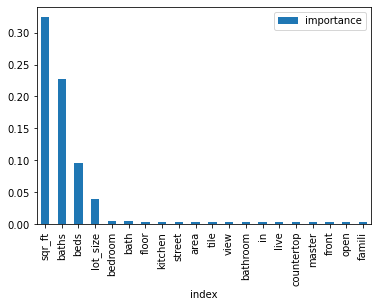

In [431]:
pd.DataFrame({
    'index': train_X.columns, 
    'importance': tuned_rf.feature_importances_
}).set_index('index').sort_values(by = 'importance', ascending = False).head(20).plot(kind = 'bar')

### Takeaways


* The most important features in determining the value of a listing are the standard objective stats - square footage, bathrooms, bedrooms, lot size. The importance may vary depending on how the model is tuned, but it is almost always those four features.
* Future improvements:
    * Leverage classification models (likely K-Nearest Neighbors) to categorize test data similar to the stats+text categorization done in prior sections
    * Take state and geolocation into account in categorization to better determine feature importance by region